## 인공지능 수업 과제 1
### Kaggle : Predict future Sales Data 분석
* Linear regression에 알맞은 기본 데이터

### Linear regression 모델링

#### 해야할 것

1. 데이터 나누기 : overfitting이 일어날수 있기 떄문
    * Test data를 보관 : hold out method
        * Train data : Train, Validation , Test
        * Validation : Hyper parameter Tuning

2. 데이터 전처리
    * 탐색적 자료 분석(EDA)
    * Feature Engineering
        * 시계열 데이터 : 년 월 일
        * 가격 : binning?/ mean?
        * category : onehot 

3. 모델링
    * 아니 근데 리니어 레그레이션을 쓸거면 연속적인 값을 사용해야되나?
    * 적합한 모델 선정 : Linear regression
    * 모델에 적합한 하이퍼 파라미터 선정
    * 다양한 전처리 경우의 수 입력
    * 학습 실행
    * 성능 평가
        * R squared
        * RMSE

## code

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rc
rc('font', family='AppleGothic')
import datetime

In [2]:
# load data
df_train = pd.read_csv("predict_future_sales_data/sales_train.csv")
df_items = pd.read_csv("predict_future_sales_data/items.csv") 
df_shops = pd.read_csv("predict_future_sales_data/shops.csv")
df_sample = pd.read_csv("predict_future_sales_data/sample_submission.csv")
df_test = pd.read_csv("predict_future_sales_data/test.csv")
df_category = pd.read_csv("predict_future_sales_data/item_categories.csv")

#### google translator : translator.translate(x, dest='en').text

In [3]:
# google translate
# categoty, shops에 러시아어를 영어로 번역 
from googletrans import Translator
translator = Translator()
df_category['item_category_name'] = df_category['item_category_name'].apply(lambda x : translator.translate(x, dest='en').text)
df_shops['shop_name'] = df_shops['shop_name'].apply(lambda x : translator.translate(x, dest='en').text)

### 1. EDA

#### missing data : 없음 

In [4]:
# check missing value 없음 
print(np.sum(pd.isnull(df_train)))
print(np.sum(pd.isnull(df_items)))
print(np.sum(pd.isnull(df_category)))
print(np.sum(pd.isnull(df_shops)))

date              0
date_block_num    0
shop_id           0
item_id           0
item_price        0
item_cnt_day      0
dtype: int64
item_name           0
item_id             0
item_category_id    0
dtype: int64
item_category_name    0
item_category_id      0
dtype: int64
shop_name    0
shop_id      0
dtype: int64


In [5]:
# item 이름 까지는 굳이 필요하지 않을것이라고 생각
del df_items['item_name']

#### category, item 병합 , 대분류 나눠주기 

In [6]:
# item, categry dataframe 병합 , item_category_id
# category 대분류 분리
df_item_category = pd.merge(df_items, df_category, on="item_category_id", how = "left")
df_item_category["big_category"] = df_item_category['item_category_name'].apply(lambda name : name.split(' - ')[0])
del df_item_category['item_category_name']
df_item_category.head()

,item_id,item_category_id,big_category
0,0,40,Movie
1,1,76,Programs
2,2,40,Movie
3,3,40,Movie
4,4,40,Movie


### category 더 줄이기

In [7]:
df_item_category.big_category.unique()
game_list = ['Игры','Games','PC Games','MAC Games','Android Games']
card_list = ['Payment cards (Cinema, Music, Games)','Payment Cards','Payment cards', 'Gifts', 'Tickets (Number)']
movie_list = ['Movie','Cinema']
service_list = ['Service','Delivery of goods',]
acc_list = ['Books','Accessories','Game consoles', 'Batteries','Programs','Game Consoles']
bm_list = ['Blank media (piece)', 'Blank media (spire)']

In [8]:
df_big = pd.DataFrame(df_item_category['big_category'])
df_big['big_category'].unique()

array(['Movie', 'Programs', 'Music', 'Games', 'PC Games', 'Cinema',
       'Books', 'Gifts', 'Игры', 'Payment cards (Cinema, Music, Games)',
       'Accessories', 'MAC Games', 'Android Games', 'Game consoles', 'PC',
       'Payment cards', 'Tickets (Number)', 'Service',
       'Delivery of goods', 'Game Consoles', 'Payment Cards',
       'Blank media (piece)', 'Blank media (spire)', 'Batteries'],
      dtype=object)

In [9]:
def change_cate(df,cate_list,name : str()):
    for i in range(len(cate_list)) : 
        df[df['big_category'] == cate_list[i]] = name


In [10]:
change_cate(df_big, game_list,'Games')
change_cate(df_big, card_list,'Card')
change_cate(df_big, movie_list,'Movie')
change_cate(df_big, service_list,'Service')
change_cate(df_big, acc_list,'Accessory')
change_cate(df_big, bm_list, 'Blank_media')
df_item_category['big_category'] = df_big

In [11]:
df_item_category

,item_id,item_category_id,big_category
0,0,40,Movie
1,1,76,Accessory
2,2,40,Movie
3,3,40,Movie
4,4,40,Movie
...,...,...,...
22165,22165,31,Games
22166,22166,54,Accessory
22167,22167,49,Accessory
22168,22168,62,Card


In [13]:
# item별 가격 mean()
df_item_price = df_train.loc[ :, ['shop_id','date_block_num','item_id','item_price','item_cnt_day']]
price = pd.DataFrame(df_item_price.groupby('item_id')['item_price'].mean())

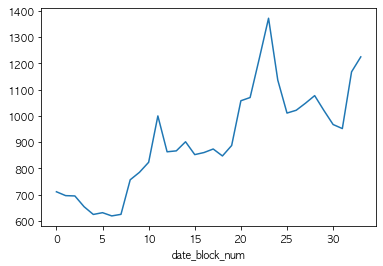

In [14]:
# 월에 따라 가격이 변함
df_item_price.groupby('date_block_num')['item_price'].mean().plot()

In [15]:
# 이상치 제거 IQR
Q1 = np.percentile(price,25)
Q3 = np.percentile(price,75)
IQR = Q3 - Q1
outlier_min = Q1 - 1.5*IQR
outlier_max = Q3 + 1.5*IQR
price[price.item_price > outlier_max ] = outlier_max 
price = price.reset_index()
# scailing
scale = price['item_price'].max() - price['item_price'].min()
price['scailing_price'] = price['item_price'] / scale

In [16]:
del price['item_price']

In [17]:
price

,item_id,scailing_price
0,0,0.031517
1,1,1.002671
2,2,0.031517
3,3,0.042928
4,4,0.031517
...,...,...
21802,22165,0.032060
21803,22166,0.081510
21804,22167,0.161762
21805,22168,0.434129


### shop을 어떻게 나눌까 ?


In [18]:
shops = df_train.copy()
shops

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
2,05.01.2013,0,25,2552,899.00,-1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0
...,...,...,...,...,...,...
2935844,10.10.2015,33,25,7409,299.00,1.0
2935845,09.10.2015,33,25,7460,299.00,1.0
2935846,14.10.2015,33,25,7459,349.00,1.0
2935847,22.10.2015,33,25,7440,299.00,1.0


In [19]:
# shop별 판매량 
sales = pd.DataFrame(shops.groupby('shop_id')['item_cnt_day'].sum())

In [20]:
# 이상치 제거 IQR
Q1 = np.percentile(sales,25)
Q3 = np.percentile(sales,75)
IQR = Q3 - Q1
outlier_min = Q1 - 1.5*IQR
outlier_max = Q3 + 1.5*IQR
sales[sales.item_cnt_day > outlier_max ] = outlier_max
sales[sales.item_cnt_day < outlier_min ] = outlier_min
sales = sales.reset_index()
# scailing
scale = sales['item_cnt_day'].max() - sales['item_cnt_day'].min()
sales['scailing_sales'] = sales['item_cnt_day'] / scale
del sales['item_cnt_day']
sales

,shop_id,scailing_sales
0,0,0.084466
1,1,0.045542
2,2,0.220962
3,3,0.204617
4,4,0.317096
5,5,0.308581
6,6,0.725154
7,7,0.483907
8,8,0.025942
9,9,0.114493


### 2. data preprocessing

#### train data, item_category 병합

In [28]:
## 시계열 데이터 변환

In [21]:
from datetime import datetime
df_train['year'] = pd.to_datetime(df_train['date']).dt.strftime('%Y')
df_train

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,year
0,02.01.2013,0,59,22154,999.00,1.0,2013
1,03.01.2013,0,25,2552,899.00,1.0,2013
2,05.01.2013,0,25,2552,899.00,-1.0,2013
3,06.01.2013,0,25,2554,1709.05,1.0,2013
4,15.01.2013,0,25,2555,1099.00,1.0,2013
...,...,...,...,...,...,...,...
2935844,10.10.2015,33,25,7409,299.00,1.0,2015
2935845,09.10.2015,33,25,7460,299.00,1.0,2015
2935846,14.10.2015,33,25,7459,349.00,1.0,2015
2935847,22.10.2015,33,25,7440,299.00,1.0,2015


#### train에 test에 없는 shop, item들이 존재 : test에 해당하는 것만 사용 / item_cnt_month 생성

In [22]:
x_train = df_train[df_train.shop_id.isin(df_test.shop_id.unique())]
x_train = x_train[x_train.item_id.isin(df_test.item_id.unique())]
x_train['date'] = x_train['date'].apply(lambda x : int(x[3:5]))
x_train = pd.DataFrame(x_train.groupby(['year','date_block_num','date','shop_id','item_id'],as_index=False)['item_cnt_day'].sum())
x_train.rename(columns={'item_cnt_day' : 'item_cnt_month', 'date' : 'month'}, inplace = True )
x_train

,year,date_block_num,month,shop_id,item_id,item_cnt_month
0,2013,0,1,2,33,1.0
1,2013,0,1,2,482,1.0
2,2013,0,1,2,491,1.0
3,2013,0,1,2,839,1.0
4,2013,0,1,2,1007,3.0
...,...,...,...,...,...,...
600154,2015,33,10,59,22087,6.0
600155,2015,33,10,59,22088,2.0
600156,2015,33,10,59,22091,1.0
600157,2015,33,10,59,22100,1.0


#### test data 처리

In [23]:
# 다음달 데이터를 예측하는 것이므로 date_block_num = 34
df_test["date_block_num"] = 34
df_test['month'] = 11
df_test['year'] = 2015
# df_test['item_price'] = 0 
# x_test = pd.merge(df_test,df_item_category, on = 'item_id', how = 'left')
df_test

,ID,shop_id,item_id,date_block_num,month,year
0,0,5,5037,34,11,2015
1,1,5,5320,34,11,2015
2,2,5,5233,34,11,2015
3,3,5,5232,34,11,2015
4,4,5,5268,34,11,2015
...,...,...,...,...,...,...
214195,214195,45,18454,34,11,2015
214196,214196,45,16188,34,11,2015
214197,214197,45,15757,34,11,2015
214198,214198,45,19648,34,11,2015


In [24]:
# train test 합쳐주기 
df_train_test = pd.concat([x_train, df_test], axis = 0)
df_train_test

,year,date_block_num,month,shop_id,item_id,item_cnt_month,ID
0,2013,0,1,2,33,1.0,NaN
1,2013,0,1,2,482,1.0,NaN
2,2013,0,1,2,491,1.0,NaN
3,2013,0,1,2,839,1.0,NaN
4,2013,0,1,2,1007,3.0,NaN
...,...,...,...,...,...,...,...
214195,2015,34,11,45,18454,NaN,214195.0
214196,2015,34,11,45,16188,NaN,214196.0
214197,2015,34,11,45,15757,NaN,214197.0
214198,2015,34,11,45,19648,NaN,214198.0


In [25]:
# item_category 합치기 
df_all = pd.merge(df_train_test,df_item_category, on = "item_id", how = "left")

In [26]:
# price 넣기
df_all = pd.merge(df_all,price, on ='item_id', how = 'left')
df_all = pd.merge(df_all,sales, on = 'shop_id', how = 'left')
df_all

,year,date_block_num,month,shop_id,item_id,item_cnt_month,ID,item_category_id,big_category,scailing_price,scailing_sales
0,2013,0,1,2,33,1.0,NaN,37,Movie,0.137388,0.220962
1,2013,0,1,2,482,1.0,NaN,73,Accessory,1.002671,0.220962
2,2013,0,1,2,491,1.0,NaN,73,Accessory,0.321290,0.220962
3,2013,0,1,2,839,1.0,NaN,73,Accessory,1.002671,0.220962
4,2013,0,1,2,1007,3.0,NaN,67,Card,0.316013,0.220962
...,...,...,...,...,...,...,...,...,...,...,...
814354,2015,34,11,45,18454,NaN,214195.0,55,Music,0.102529,0.302325
814355,2015,34,11,45,16188,NaN,214196.0,64,Card,0.683037,0.302325
814356,2015,34,11,45,15757,NaN,214197.0,55,Music,0.107654,0.302325
814357,2015,34,11,45,19648,NaN,214198.0,40,Movie,0.053305,0.302325


In [27]:
# get dummy
df_train_test = pd.get_dummies(df_all, columns = ['big_category'])
df_train_test

,year,date_block_num,month,shop_id,item_id,item_cnt_month,ID,item_category_id,scailing_price,scailing_sales,big_category_Accessory,big_category_Card,big_category_Games,big_category_Movie,big_category_Music,big_category_PC,big_category_Service
0,2013,0,1,2,33,1.0,NaN,37,0.137388,0.220962,0,0,0,1,0,0,0
1,2013,0,1,2,482,1.0,NaN,73,1.002671,0.220962,1,0,0,0,0,0,0
2,2013,0,1,2,491,1.0,NaN,73,0.321290,0.220962,1,0,0,0,0,0,0
3,2013,0,1,2,839,1.0,NaN,73,1.002671,0.220962,1,0,0,0,0,0,0
4,2013,0,1,2,1007,3.0,NaN,67,0.316013,0.220962,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
814354,2015,34,11,45,18454,NaN,214195.0,55,0.102529,0.302325,0,0,0,0,1,0,0
814355,2015,34,11,45,16188,NaN,214196.0,64,0.683037,0.302325,0,1,0,0,0,0,0
814356,2015,34,11,45,15757,NaN,214197.0,55,0.107654,0.302325,0,0,0,0,1,0,0
814357,2015,34,11,45,19648,NaN,214198.0,40,0.053305,0.302325,0,0,0,1,0,0,0


In [34]:
del df_train_test['ID']
df_train_test

,year,date_block_num,month,shop_id,item_id,item_cnt_month,item_category_id,scailing_price,scailing_sales,big_category_Accessory,big_category_Card,big_category_Games,big_category_Movie,big_category_Music,big_category_PC,big_category_Service
0,2013,0,1,2,33,1.0,37,0.137388,0.220962,0,0,0,1,0,0,0
1,2013,0,1,2,482,1.0,73,1.002671,0.220962,1,0,0,0,0,0,0
2,2013,0,1,2,491,1.0,73,0.321290,0.220962,1,0,0,0,0,0,0
3,2013,0,1,2,839,1.0,73,1.002671,0.220962,1,0,0,0,0,0,0
4,2013,0,1,2,1007,3.0,67,0.316013,0.220962,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
814354,2015,34,11,45,18454,NaN,55,0.102529,0.302325,0,0,0,0,1,0,0
814355,2015,34,11,45,16188,NaN,64,0.683037,0.302325,0,1,0,0,0,0,0
814356,2015,34,11,45,15757,NaN,55,0.107654,0.302325,0,0,0,0,1,0,0
814357,2015,34,11,45,19648,NaN,40,0.053305,0.302325,0,0,0,1,0,0,0


In [35]:
# train,test split
new_test = df_train_test[df_train_test['date_block_num'] == 34].copy()
new_train = df_train_test[df_train_test['date_block_num'] < 34].copy()

### validation

In [36]:
new_val = new_train[new_train['date_block_num'] == 32 ]
new_train = new_train[new_train['date_block_num'] != 32]


In [37]:
new_train_y = new_train['item_cnt_month'].copy()
del new_train['item_cnt_month']

In [38]:
new_val_y = new_val['item_cnt_month'].copy()
del new_val['item_cnt_month']

In [39]:
from sklearn.linear_model import LinearRegression
model = LinearRegression(fit_intercept = True)
model = model.fit(new_train,new_train_y)
y_val_pred = model.predict(new_val)

In [40]:
# item_id포함
from sklearn.metrics import median_absolute_error, mean_squared_error, r2_score

print("MAE : ",median_absolute_error(new_val_y,y_val_pred))
print("RMSE : ",mean_squared_error(new_val_y,y_val_pred)**0.5)
print("R2 score", r2_score(new_val_y,y_val_pred))

MAE :  1.2482861481286527
RMSE :  6.6829719207371046
R2 score 0.0328643969920126


In [203]:
# scailing shop
print("MAE : ",median_absolute_error(new_val_y,y_val_pred))
print("RMSE : ",mean_squared_error(new_val_y,y_val_pred)**0.5)
print("R2 score", r2_score(new_val_y,y_val_pred))

MAE :  1.2575829544823343
RMSE :  11.690923035028579
R2 score 0.021284417631168173


In [45]:
# 3
from sklearn.metrics import median_absolute_error, mean_squared_error, r2_score
print("MAE : ",median_absolute_error(new_val_y,y_val_pred))
print("RMSE : ",mean_squared_error(new_val_y,y_val_pred)**0.5)
print("R2 score", r2_score(new_val_y,y_val_pred))

MAE :  1.2416636911309453
RMSE :  6.682688958866575
R2 score 0.032946293701738294


In [41]:
new_test

,year,date_block_num,month,shop_id,item_id,item_cnt_month,item_category_id,scailing_price,scailing_sales,big_category_Accessory,big_category_Card,big_category_Games,big_category_Movie,big_category_Music,big_category_PC,big_category_Service
600159,2015,34,11,5,5037,NaN,19,1.002671,0.308581,0,0,1,0,0,0,0
600160,2015,34,11,5,5320,NaN,55,NaN,0.308581,0,0,0,0,1,0,0
600161,2015,34,11,5,5233,NaN,19,0.435141,0.308581,0,0,1,0,0,0,0
600162,2015,34,11,5,5232,NaN,23,0.429563,0.308581,0,0,1,0,0,0,0
600163,2015,34,11,5,5268,NaN,20,NaN,0.308581,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
814354,2015,34,11,45,18454,NaN,55,0.102529,0.302325,0,0,0,0,1,0,0
814355,2015,34,11,45,16188,NaN,64,0.683037,0.302325,0,1,0,0,0,0,0
814356,2015,34,11,45,15757,NaN,55,0.107654,0.302325,0,0,0,0,1,0,0
814357,2015,34,11,45,19648,NaN,40,0.053305,0.302325,0,0,0,1,0,0,0


### prediction

In [50]:
# validation 뺴고 할때
new_train = df_train_test[df_train_test['date_block_num'] < 34].copy()
new_test = df_train_test[df_train_test['date_block_num'] == 34].copy()
new_train_y = new_train['item_cnt_month'].copy()
del new_train['item_cnt_month']

In [51]:
del new_test['item_cnt_month']
# scailing_price가 training에 없는 경우 
new_test['scailing_price'] = new_test['scailing_price'].fillna(0)
new_test

,year,date_block_num,month,shop_id,item_id,item_category_id,scailing_price,scailing_sales,big_category_Accessory,big_category_Card,big_category_Games,big_category_Movie,big_category_Music,big_category_PC,big_category_Service
600159,2015,34,11,5,5037,19,1.002671,0.308581,0,0,1,0,0,0,0
600160,2015,34,11,5,5320,55,0.000000,0.308581,0,0,0,0,1,0,0
600161,2015,34,11,5,5233,19,0.435141,0.308581,0,0,1,0,0,0,0
600162,2015,34,11,5,5232,23,0.429563,0.308581,0,0,1,0,0,0,0
600163,2015,34,11,5,5268,20,0.000000,0.308581,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
814354,2015,34,11,45,18454,55,0.102529,0.302325,0,0,0,0,1,0,0
814355,2015,34,11,45,16188,64,0.683037,0.302325,0,1,0,0,0,0,0
814356,2015,34,11,45,15757,55,0.107654,0.302325,0,0,0,0,1,0,0
814357,2015,34,11,45,19648,40,0.053305,0.302325,0,0,0,1,0,0,0


In [52]:
new_test.isnull().sum()

year                      0
date_block_num            0
month                     0
shop_id                   0
item_id                   0
item_category_id          0
scailing_price            0
scailing_sales            0
big_category_Accessory    0
big_category_Card         0
big_category_Games        0
big_category_Movie        0
big_category_Music        0
big_category_PC           0
big_category_Service      0
dtype: int64

In [53]:
# testset
model = LinearRegression(fit_intercept = True)
model = model.fit(new_train,new_train_y)
y_new = model.predict(new_test)

In [54]:
y_new

array([2.32281233, 0.54585283, 2.97024182, ..., 0.60309063, 1.15835631,
       0.27727722])

In [55]:
submission = pd.DataFrame(y_new).reset_index()
submission

,index,0
0,0,2.322812
1,1,0.545853
2,2,2.970242
3,3,2.911938
4,4,3.446296
...,...,...
214195,214195,0.707302
214196,214196,2.554545
214197,214197,0.603091
214198,214198,1.158356


In [56]:
submission.rename(columns={'index' : 'ID', 0 : 'item_cnt_month'}, inplace = True )

In [57]:
submission

,ID,item_cnt_month
0,0,2.322812
1,1,0.545853
2,2,2.970242
3,3,2.911938
4,4,3.446296
...,...,...
214195,214195,0.707302
214196,214196,2.554545
214197,214197,0.603091
214198,214198,1.158356


In [58]:
submission.to_csv('submission.csv', index = False)

In [105]:
submission

,ID,item_cnt_month
0,0,2.768490
1,1,1.111614
2,2,3.392656
3,3,3.351053
4,4,3.854564
...,...,...
214195,214195,1.507746
214196,214196,3.388097
214197,214197,1.390996
214198,214198,1.943827
